# 1 Load Data

In [1]:
import pandas as pd

df = pd.read_csv('./dataset/fruit.csv')
df

,Period,Banana,Orange
0,2005M01,0.589058,0.640125
1,2005M02,0.890476,0.742358
2,2005M03,0.792300,1.109062
3,2005M04,0.592502,1.174966
4,2005M05,0.618338,1.095678
...,...,...,...
209,2022M06,1.438515,0.938663
210,2022M07,1.526010,0.841808
211,2022M08,1.670689,0.932844
212,2022M09,1.619018,0.934166


# 2 Import Relevant Func

In [2]:
from model import Attn4TS                   # attention model for time series
from dataloader import DataSet, collate_fn  # dataloader
from trainer import train_model, SE         # trainer

# parameters
i_dim = 10 # input sequence length
o_dim = 1  # predict length
learning_rate = 1e-4
weight_decay = 1e-2
n_epoch = 64
batch_size = 100
val_date = 10
test_date = 10

# init model, dataset
ts = Attn4TS(input_dim=i_dim, output_dim=o_dim)
data_b = DataSet(df['Banana'], i_dim, o_dim, val_date, test_date)

# 3 Train Model with Default Settings

Testing Standard Error 0.9901


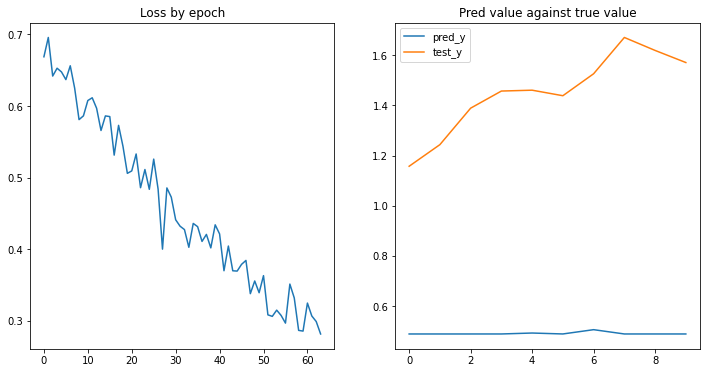

In [3]:
# train model
m, loss = train_model(ts, data_b, SE
                , learning_rate, weight_decay
                , n_epoch, batch_size)


# see testing set performance
test_x, test_y = data_b.get_test_batch()
test_se = SE(test_y, m(test_x))
print(f'Testing Standard Error {round(test_se.mean().tolist(), 4)}')

import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# loss plot
ax1.plot(loss)
ax1.title.set_text('Loss by epoch')

# pred plot
common_x = list(range(len(test_y)))
ax2.plot(common_x, m(test_x).view(-1).tolist(), label='pred_y')
ax2.plot(common_x, test_y.view(-1).tolist(), label='test_y')
ax2.title.set_text('Pred value against true value')
ax2.legend()

plt.show()

# 4 Grid Search for Better Performance

In [4]:
from tools import log_lin_space             # grid generator

lr_space = log_lin_space(-5, -2, 3, 3)
wd_space = log_lin_space(-5, -2, 3, 3)

result_space = []

for lr in lr_space:
    for wd in lr_space:
        ts = Attn4TS(input_dim=i_dim, output_dim=o_dim)
        data_b = DataSet(df['Banana'], i_dim, o_dim, val_date, test_date)

        m, loss = train_model(ts, data_b, SE
                        , lr, wd
                        , n_epoch, batch_size)

        val_x, val_y = data_b.get_val_batch()
        pred_y = m(val_x)
        val_se = SE(val_y, pred_y).mean().tolist()
        result_space.append([lr, wd, val_se])

result = pd.DataFrame(result_space, columns=['lr', 'wd', 'se'])
min_res = result[result['se']==result['se'].min()]

min_res

,lr,wd,se
52,0.000949,0.02,0.018429


Testing Standard Error 0.2774


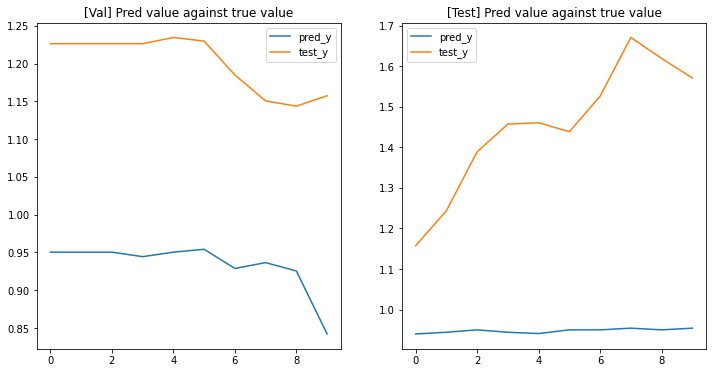

In [5]:
m_lr = min_res['lr'].tolist()[0]
m_wd = min_res['wd'].tolist()[0]

m, loss = train_model(ts, data_b, SE
                , m_lr, m_wd
                , n_epoch, batch_size)

val_x, val_y = data_b.get_val_batch()
pred_y_val = m(val_x)

test_x, test_y = data_b.get_test_batch()
pred_y_test = m(test_x)
test_se = SE(test_y, pred_y_test)

# see testing set performance
print(f'Testing Standard Error {round(test_se.mean().tolist(), 4)}')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# loss plot
common_x = list(range(len(test_y)))
ax1.plot(common_x, pred_y_val.view(-1).tolist(), label='pred_y')
ax1.plot(common_x, val_y.view(-1).tolist(), label='test_y')
ax1.title.set_text('[Val] Pred value against true value')
ax1.legend()
# pred plot
common_x = list(range(len(test_y)))
ax2.plot(common_x, pred_y_test.view(-1).tolist(), label='pred_y')
ax2.plot(common_x, test_y.view(-1).tolist(), label='test_y')
ax2.title.set_text('[Test] Pred value against true value')
ax2.legend()

plt.show()

Test SE improved a lot compared to default.